<a href="https://colab.research.google.com/github/mboaglio/1-Regresi-n-Lineal-SGD/blob/master/Trabajo_Final_CNN_Style_Transfer_Marcos_Boaglio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Final** 
## Diplomatura en Deep Learning 2019
#### **Alumno:** Marcos Boaglio (mboaglio@itba.edu.ar)


# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.
En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.
Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

from IPython.display import Image, display
import os

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
basedir = "/content/drive/My Drive/2019 ITBA - Diplomatura Deep Learning/TrabajoFinal"
inputdir = basedir + "/input"
outputdir = basedir + "/output"

# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path(inputdir+"/Neckarfront.jpg")
style_reference_image_path = Path(inputdir+"/La_noche_estrellada1.jpg")
result_prefix = Path(outputdir)
iterations = 10


# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?


## **Respuesta**: Son los hiperparametros que definen el peso relativo entre la loss de la imagen de contenido y la imagen de estilo. Se utilizan en la loss a minimizar.

In [4]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/


## **Respuesta :** La celda carga la imagen de contenido, la transforma en array, le agrega una dimensión y prepara la imagen para ser procesada por VGG. Es decir, la adapta al formato en el que fue entrenada la red VGG. Esto lo hace porque Keras trabaja con batches de imagenes (la nueva dimensión agrega el numero de muestra) y, ademas, para poder generar imagenes compatibles con VGG durante el proceso de style transfer.

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?


## **Respuesta:** En forma muy concisa: Es el proceso inverso de la celda anterior. transforma la imagen "VGG19" para que pueda ser utilizada como imagen estándar.

In [7]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

### - ¿Qué es la matriz de Gram?¿Para qué se usa?
### - ¿Por qué se permutan las dimensiones de x?


##**Respuesta:**
###- ¿Qué es la matriz de Gram?¿Para qué se usa?
Es la matriz de correlaciones entre canales. La correlación es entre cada feature y es una forma de entender cuanto se activan juntos determinados features. Define el estilo y tambien se llama "Matriz de Estilo". Se calcula para ambas imagenes y se usa para armar la loss de estilo.

###- ¿Por qué se permutan las dimensiones de x?
Para poder multiplicarla

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

### Explicar qué mide cada una de las losses en las siguientes tres celdas.

##**Respuesta:**

1)
**style_loss:** Define la loss de estilo y devuelve la suma de cuadrados de la diferencia elemento a elemento entre las matrices de Gram de estilo y la combinada.

2) **content_loss:** Define la loss de contenido y devuelve la suma de cuadrados de la diferencia elemento a elemento entre las matrices que tienen los features del layer de activación pasado por la loss total.

3) **total_variation_loss:** define la loss de la imagen final. 

In [13]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [14]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [15]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [16]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [17]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?
 


## **Respuesta:** (aclaracion: son dos celdas)
Definen los componenetes del objeto *Evaluator*. Esta clase permite calcular la loss y los gradientes en una sola pasada mientras los recupera a través de dos funciones separadas, "loss" y "grads". Esto se hace porque scipy.optimize requiere funciones separadas para la loss y los gradientes, pero calcularlas por separado sería ineficiente.

###¿Qué hace la función fmin_l_bfgs_b?
Minimiza una función usando el algoritmo L-BFGS. forma parte de la librería scipy y, en este caso, se utiliza para minimizar la loss.

###¿En qué se diferencia con la implementación del paper? 
En el paper se usa gradient descent desde una imagen de ruido blanco para encontrar otra imagen que coincida con la representación de estilo de la imagen original. Esto se hace minimizando la distancia cuadrática media entre las entradas de la matriz de Gram de la imagen original y la matriz de Gram de la imagen que se generará.


### ¿Se puede utilizar alguna alternativa?
Se podría usar cualquier otro optimizador como, por ejemplo, Adam.

In [18]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [19]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [20]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure( figsize = [ 6.4 * 1 , 4.8 * 1 ])
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


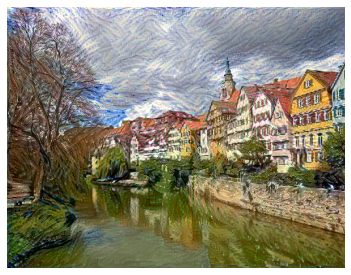

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

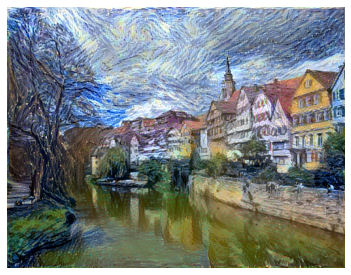

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

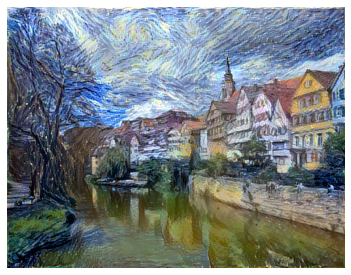

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

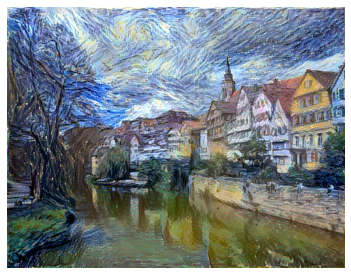

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

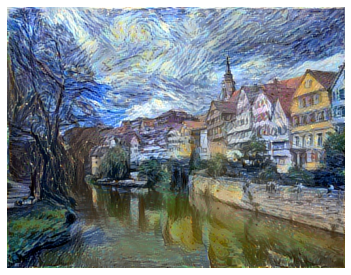

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

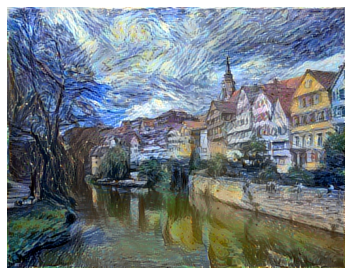

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

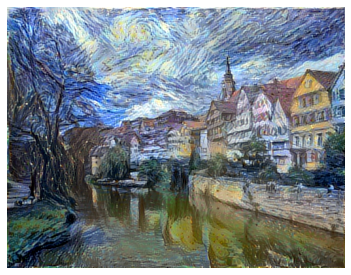

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

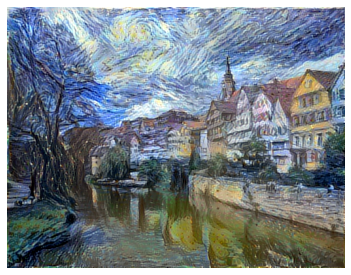

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

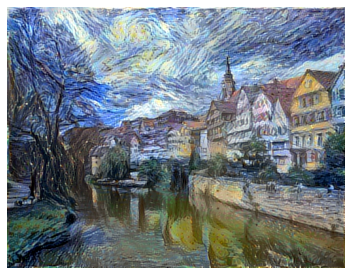

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

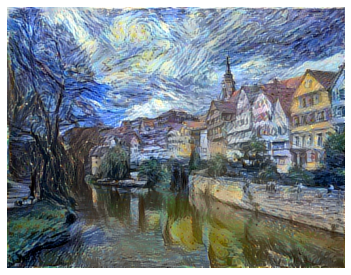

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

In [21]:
from IPython.display import Image, display
filelist = []
iterations = 100

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)

    # guardo e imprimo 1 cada 10 imagenes
    if i % 10 == 0:
      # save current generated image
      img = deprocess_image(x.copy())

      filename = 'output_iteration_{}.png'.format(i)
      fname = result_prefix / filename
      save_img(fname, img)
      end_time = time.time()

      filelist.append(outputdir + "/" + filename)
    else:
      showImagesHorizontally(filelist)
      filelist = []



# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)
## **Respuesta:**
A medida que aumenta *style_weight*, aumenta el énfasis en el estilo. Y a medida que aumenta el *content_weight*, aumenta el énfasis en mantener la imagen original. Es importante aclarar que en realidad lo que impacta en el algoritmo es la relacion entre ambos hiperparámetros (*style_weight*/*content_weight*) ya que genera el énfasis para un lado o para el otro en la loss total compuesta por la de la imagen y el estilo.
Por esta razón es que, si bien en el codigo se pueden agregar seteos a todos los hiperparametros en listas, el unico hiperparámetro que se modifica es el de *style_weights*.

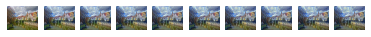

In [22]:
outputdir = basedir + "/output_ejercicio_8"

# Definimos las imagenes que vamos a utilizar, y el directorio de salida
result_prefix = Path(outputdir)
filelist = []

# Definimos/redefinimos parametros e hiperparametros
iterations = 100
total_variation_weights = [0.1]
style_weights = [1, 1000, 1000000000]
content_weights = [1]

for total_variation_weight in total_variation_weights:
  for style_weight in style_weights:
    filelist = []

    for content_weight in content_weights:
 
      # get tensor representations of our images
      # K.variable convierte un numpy array en un tensor, para 
      base_image = K.variable(preprocess_image(base_image_path))
      style_reference_image = K.variable(preprocess_image(style_reference_image_path))

      combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

      # combine the 3 images into a single Keras tensor
      input_tensor = K.concatenate([base_image,
                                    style_reference_image,
                                    combination_image], axis=0)

      # build the VGG19 network with our 3 images as input
      # the model will be loaded with pre-trained ImageNet weights
      model = vgg19.VGG19(input_tensor=input_tensor,
                          weights='imagenet', include_top=False)
 
      # get the symbolic outputs of each "key" layer (we gave them unique names).
      outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

      # Armamos la loss total
      loss = K.variable(0.0)
      layer_features = outputs_dict['block5_conv2']
      base_image_features = layer_features[0, :, :, :]
      combination_features = layer_features[2, :, :, :]
      loss = loss + content_weight * content_loss(base_image_features,
                                                  combination_features)

      feature_layers = ['block1_conv1', 'block2_conv1',
                        'block3_conv1', 'block4_conv1',
                        'block5_conv1']
      for layer_name in feature_layers:
          layer_features = outputs_dict[layer_name]
          style_reference_features = layer_features[1, :, :, :] 
          combination_features = layer_features[2, :, :, :]
          sl = style_loss(style_reference_features, combination_features)
          loss = loss + (style_weight / len(feature_layers)) * sl

      loss = loss + total_variation_weight * total_variation_loss(combination_image)

      grads = K.gradients(loss, combination_image)

      outputs = [loss]
      if isinstance(grads, (list, tuple)):
          outputs += grads
      else:
          outputs.append(grads)

      f_outputs = K.function([combination_image], outputs)

      evaluator8 = Evaluator()

      # run scipy-based optimization (L-BFGS) over the pixels of the generated image
      # so as to minimize the neural style loss
      x = preprocess_image(base_image_path)

      # Loops con variaciones de los hiperparametros

      for i in range(iterations):
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator8.loss, x.flatten(),
                                        fprime=evaluator8.grads, maxfun=20)
        # guardo e imprimo 1 cada 10 imagenes
        if i % 10 == 0:
          # save current generated image
          img = deprocess_image(x.copy())

          filename = 'output_at_cw_{}_sw_{}_tvw_{}_iteration_{}.png'.format(content_weight,style_weight,total_variation_weight,i)
          fname = result_prefix / filename
          save_img(fname, img)
          end_time = time.time()

          filelist.append(outputdir + "/" + filename)
 
    # Muestro las imagenes en cada cambio del hyperparametry de style
    showImagesHorizontally(filelist)



# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

## **Respuesta:**

In [ ]:
inputbasedir = basedir + "/input_ejercicio_9/base/"
inputstylesdir = basedir + "/input_ejercicio_9/styles/"
outputbasedir = basedir + "/output_ejercicio_9/"

# Definimos/redefinimos parametros e hiperparametros
iterations = 100
total_variation_weights = [0.1]
style_weights = [1,1000,100000]
content_weights = [1]

# Loop sobre todas las imagenes base del directorio
for base_image_name_string in os.listdir(inputbasedir):
  base_image_path = Path(inputbasedir+base_image_name_string)
  
  # Loop sobre todos los estilos del directorio
  for style_reference_image_name_string in os.listdir(inputstylesdir):
    style_reference_image_path = Path(inputstylesdir+style_reference_image_name_string)
    outputdir = outputbasedir + base_image_name_string + "_" + style_reference_image_name_string
    !mkdir "$outputdir"
    result_prefix = Path(outputdir)
  
    # Loops sobre variaciones de Hiperparámetros
    # Loop sobre el peso total de variación
    for total_variation_weight in total_variation_weights:

      # Loop sobre el peso del Estilo
      for style_weight in style_weights:
        filelist = []

        # Loop sobre el peso del contenido
        for content_weight in content_weights:
    
          # get tensor representations of our images
          # K.variable convierte un numpy array en un tensor, para 
          base_image = K.variable(preprocess_image(base_image_path))
          style_reference_image = K.variable(preprocess_image(style_reference_image_path))

          combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

          # combine the 3 images into a single Keras tensor
          input_tensor = K.concatenate([base_image,
                                        style_reference_image,
                                        combination_image], axis=0)

          # build the VGG19 network with our 3 images as input
          # the model will be loaded with pre-trained ImageNet weights
          model = vgg19.VGG19(input_tensor=input_tensor,
                              weights='imagenet', include_top=False)

          # get the symbolic outputs of each "key" layer (we gave them unique names).
          outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

          # Armamos la loss total
          loss = K.variable(0.0)
          layer_features = outputs_dict['block5_conv2']
          base_image_features = layer_features[0, :, :, :]
          combination_features = layer_features[2, :, :, :]
          loss = loss + content_weight * content_loss(base_image_features,
                                                      combination_features)

          feature_layers = ['block1_conv1', 'block2_conv1',
                            'block3_conv1', 'block4_conv1',
                            'block5_conv1']
          for layer_name in feature_layers:
              layer_features = outputs_dict[layer_name]
              style_reference_features = layer_features[1, :, :, :] 
              combination_features = layer_features[2, :, :, :]
              sl = style_loss(style_reference_features, combination_features)
              loss = loss + (style_weight / len(feature_layers)) * sl

          loss = loss + total_variation_weight * total_variation_loss(combination_image)

          grads = K.gradients(loss, combination_image)

          outputs = [loss]
          if isinstance(grads, (list, tuple)):
              outputs += grads
          else:
              outputs.append(grads)

          f_outputs = K.function([combination_image], outputs)

          evaluator9 = Evaluator()

          # run scipy-based optimization (L-BFGS) over the pixels of the generated image
          # so as to minimize the neural style loss
          x = preprocess_image(base_image_path)

          # Loop sobre iteraciones
          for i in range(iterations):
            start_time = time.time()
            x, min_val, info = fmin_l_bfgs_b(evaluator9.loss, x.flatten(),
                                            fprime=evaluator9.grads, maxfun=20)
            
            # guardo e imprimo 1 cada 10 imagenes
            if i % 10 == 0:
              # save current generated image
              img = deprocess_image(x.copy())

              filename = '{}_{}_at_cw_{}_sw_{}_tvw_{}_iteration_{}.png'.format(base_image_name_string,style_reference_image_name_string , content_weight,style_weight,total_variation_weight,i)
              fname = result_prefix / filename
              save_img(fname, img)
              end_time = time.time()

              filelist.append(outputdir + "/" + filename)
    
        # Muestro las imagenes en cada cambio de style
        showImagesHorizontally(filelist)

mkdir: cannot create directory ‘/content/drive/My Drive/2019 ITBA - Diplomatura Deep Learning/TrabajoFinal/output_ejercicio_9/machupichu.JPG_Kandinsky1.jpg’: File exists
